In [1]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 15})

Let's look at a summary of the throughput over a period of time. Using a boxplot (similar to LatencySummary notebook), we can look at the throughput distribution of each link over time to get a feel for how stable each link's throughput is. This uses the es-atlas.cern.ch instance of Kibana, and requires authentication.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from elasticsearch import Elasticsearch, exceptions as es_exceptions

#Create instance of ElasticSearch using the Atlas host server
es = Elasticsearch(hosts=[{'host':'es-atlas.cern.ch', 'port':9202}],
                   http_auth=('es-atlas', 'v~$&<J8/cG9]*eQ@'),
                   timeout=60)

In [23]:
#Get link names
linkName = ['Australia-ATLAS', 'Taiwan-LCG2', 'BEIJING-LCG2', 'SPRACE',
            'T2-TH-CUNSTDA','EELA-UTFSM', 'TOKYO-LCG2', 'CA-VICTORIA-WESTGRID-T2',
            'ITEP', 'SFU-LCG2','TRIUMF-LCG2', 'UFlorida-HPC', 'UTA_SWT2',
            'SARA-MATRIX', 'WT2', 'INDIACMS-TIFR', 'BU_ATLAS_Tier2', 'LUCILLE',
            'OU_OCHEP_SWT2', 'Nebraska', 'MWT2', 'AGLT2', 'GLOW', 'Vanderbilt',
            'CA-SCINET-T2', 'ru-PNPI', 'BNL-ATLAS', 'RRC-KI',
            'CA-MCGILL-CLUMEQ-T2', 'AM-04-YERPHI', 'CYFRONET-LCG2', 'RRC-KI-T1',
            'CSCS-LCG2', 'RU-Protvino-IHEP', 'RAL-LCG2', 'JINR-T1', 'INFN-BARI',
            'FMPhI-UNIBA', 'JINR-LCG2', 'INFN-ROMA1', 'pic', 'RO-16-UAIC', 
            'FI_HIP_T2', 'RO-07-NIPNE', 'RO-02-NIPNE', 'IFCA-LCG2', 'DESY-ZN',
            'INFN-NAPOLI-ATLAS', 'BEgrid-ULB-VUB', 'DESY-HH',
            'UKI-NORTHGRID-LANCS-HEP', 'NDGF-T1', 'INFN-T1', 'IN2P3-LPC',
            'IEPSAS-Kosice', 'IFIC-LCG2', 'UKI-SCOTGRID-GLASGOW',
            'UKI-NORTHGRID-LIV-HEP', 'BUDAPEST', 'UKI-SCOTGRID-ECDF',
            'UKI-SCOTGRID-DURHAM', 'FZK-LCG2', 'UKI-SOUTHGRID-OX-HEP',
            'UAM-LCG2', 'UKI-NORTHGRID-MAN-HEP', 'UKI-SOUTHGRID-CAM-HEP',
            'UKI-SOUTHGRID-SUSX', 'INFN-FRASCATI', 'UKI-SOUTHGRID-BHAM-HEP',
            'IN2P3-CPPM', 'UKI-LT2-QMUL', 'praguelcg2', 'UKI-SOUTHGRID-RALPP',
            'GoeGrid', 'UKI-LT2-UCL-HEP', 'GRIF', 'wuppertalprod', 'IN2P3-LAPP',
            'IN2P3-LPSC', 'INFN-MILANO-ATLASC', 'IN2P3-CC']

In [4]:
import ast

query = '''{
  "size": 0,
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "dst:%s*",
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "timestamp": {
                  "gte": 1468496174553,
                  "lte": 1468582574554,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "aggs": {
    "2": {
      "date_histogram": {
        "field": "timestamp",
        "interval": "30m",
        "time_zone": "Europe/Berlin",
        "min_doc_count": 1,
        "extended_bounds": {
          "min": 1468496174553,
          "max": 1468582574554
        }
      },
      "aggs": {
        "1": {
          "avg": {
            "field": "%s"
          }
        }
      }
    }
  }
}'''

Since the atlas_ddm-metrics indices have just recently started filling, I can only look at
data from a 24-hour period currently. I am going to compare the three different gauges of
throughput: FAX, dashboard readout, and FTS.

In [24]:
#Initialize containers for three different throughput and corresponding timestamp values

totalFaxEpochTime = []
totalDashEpochTime = []
totalFtsEpochTime = []

faxThroughput = []
dashThroughput = []
ftsThroughput = []

for i in range(len(linkName)):
    queryFax = ast.literal_eval(query%(linkName[i],'mbps-fax-1h'))
    queryDash = ast.literal_eval(query%(linkName[i],'mbps-dashb-1h'))
    queryFts = ast.literal_eval(query%(linkName[i],'mbps-fts-1h'))    
    
    faxResponse = es.search(index="atlas_ddm-metrics*", body=queryFax, request_timeout=600)
    dashResponse = es.search(index="atlas_ddm-metrics*", body=queryDash, request_timeout=600)
    ftsResponse = es.search(index="atlas_ddm-metrics*", body=queryFts, request_timeout=600)
    mbpsFax = []
    mbpsDash = []
    mbpsFts = []
    
    faxEpochTime = []
    dashEpochTime = []
    ftsEpochTime = []
    
    for r in faxResponse['aggregations']['2']['buckets']:
        #Get field value and timestamp
        mbpsFax.append(r['1']['value'])
        faxEpochTime.append(r['key'])
        
    for r in dashResponse['aggregations']['2']['buckets']:

        mbpsDash.append(r['1']['value'])
        dashEpochTime.append(r['key'])
        
    for r in ftsResponse['aggregations']['2']['buckets']:        
        mbpsFts.append(r['1']['value'])
        ftsEpochTime.append(r['key'])

## remove value/key pairs that are empty (Turn this into function to save space?)  ##      
    mbpsFax = np.array(mbpsFax,dtype=np.float)
    mbpsDash = np.array(mbpsDash,dtype=np.float)
    mbpsFts = np.array(mbpsFts,dtype=np.float)
    
    faxEpochTime =  np.array(faxEpochTime,dtype=np.float)
    dashEpochTime = np.array(dashEpochTime,dtype=np.float)
    ftsEpochTime = np.array(ftsEpochTime,dtype=np.float)
    
    faxIndices = np.logical_not(np.isnan(mbpsFax))
    dashIndices = np.logical_not(np.isnan(mbpsDash))
    ftsIndices = np.logical_not(np.isnan(mbpsFts))

    mbpsFax = mbpsFax[faxIndices]
    faxEpochTime = faxEpochTime[faxIndices]

    mbpsDash = mbpsDash[dashIndices]
    dashEpochTime = dashEpochTime[dashIndices]    

    mbpsFts = mbpsFts[ftsIndices]
    ftsEpochTime = ftsEpochTime[ftsIndices]
###############
    
    faxThroughput.append(mbpsFax)
    dashThroughput.append(mbpsDash)
    ftsThroughput.append(mbpsFts)

    totalFaxEpochTime.append(faxEpochTime)
    totalDashEpochTime.append(dashEpochTime) 
    totalFtsEpochTime.append(ftsEpochTime)

()

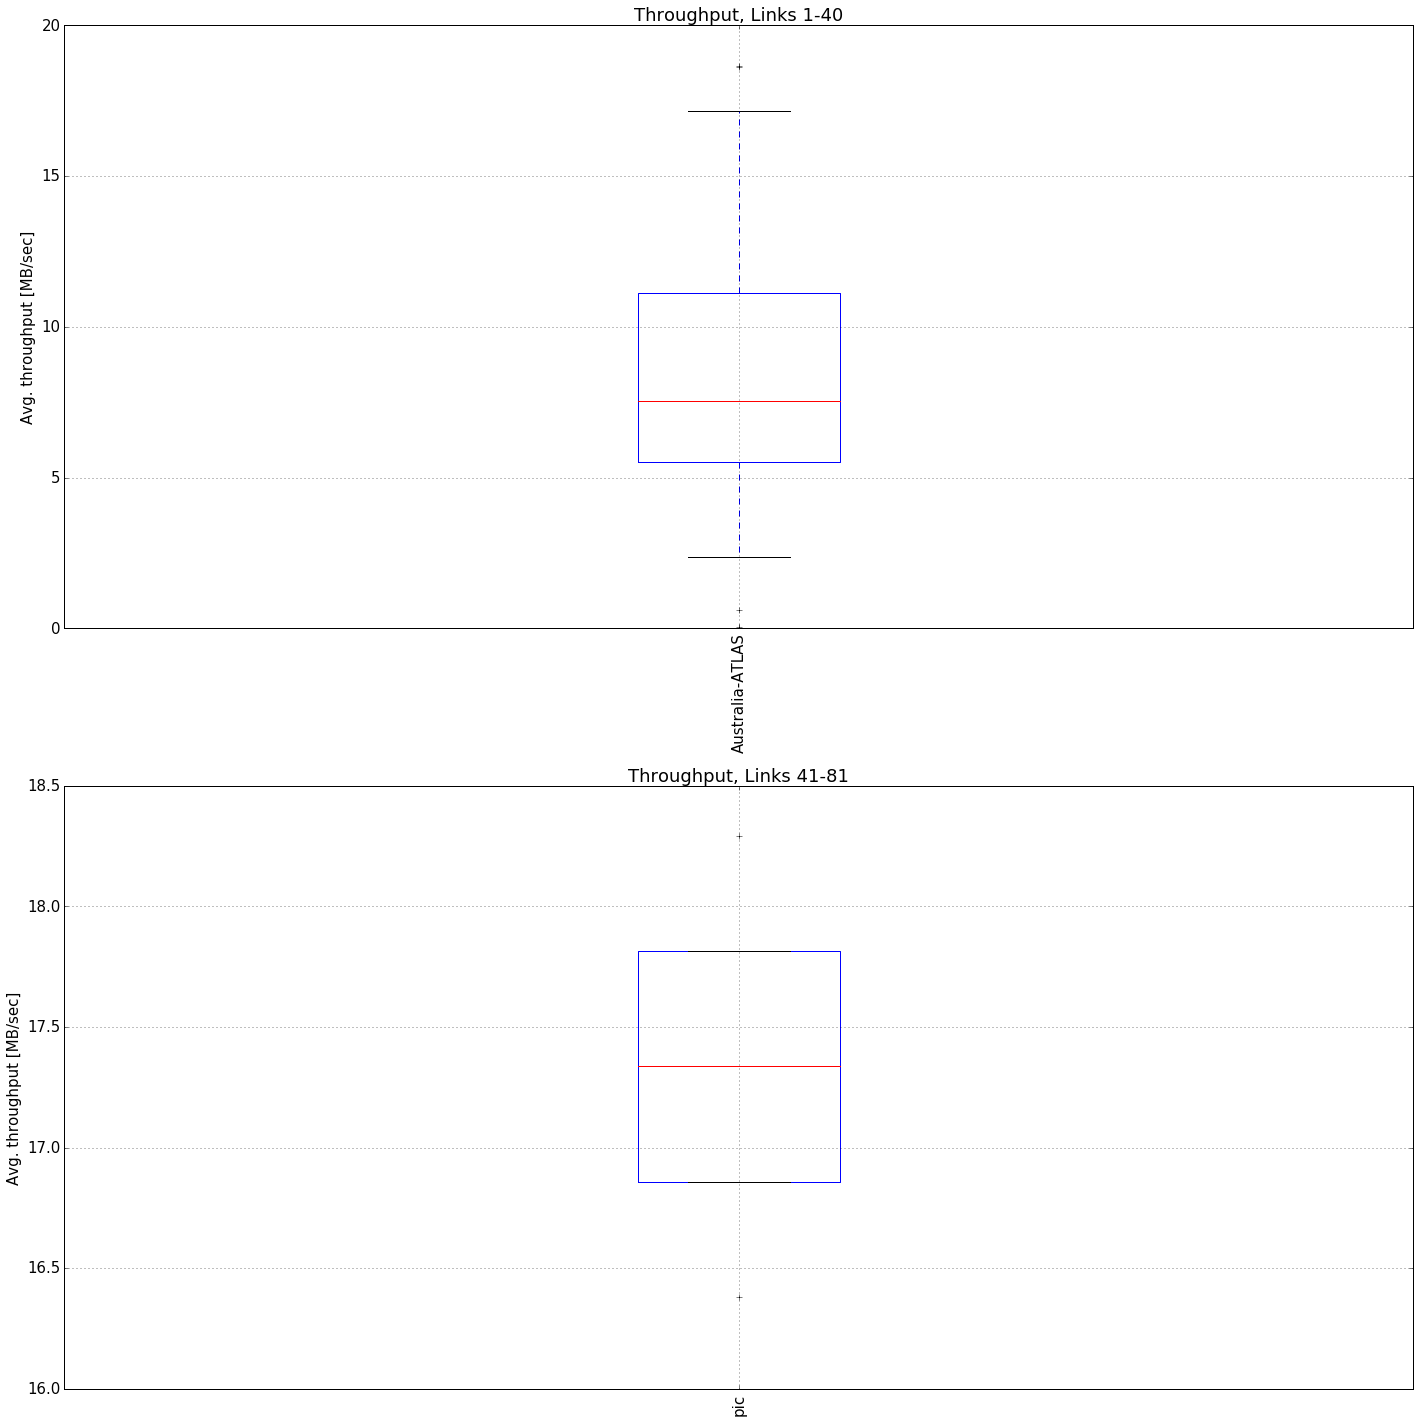

In [34]:
#Show summary for Fax MB/s

plt.figure(figsize=(20,20))

plt.subplot(211)
plt.boxplot(dashThroughput[0:40], whis=[5,95], showfliers=True)
ax = plt.gca() 
ax.xaxis.set_ticklabels(linkName[0:40])
plt.xticks(size=15,rotation= 90)
plt.grid()
plt.ylabel('Avg. throughput [MB/sec]')
plt.title('Throughput, Links 1-40')

plt.subplot(212)
plt.boxplot(dashThroughput[40:], whis=[5,95], showfliers=True)
ax = plt.gca() 
ax.xaxis.set_ticklabels(linkName[40:])
plt.xticks(size=15,rotation= 90)
plt.ylabel('Avg. throughput [MB/sec]')
plt.title('Throughput, Links 41-81')
plt.grid()

plt.tight_layout()

In [26]:
faxThroughputHist = dict(zip(linkName, faxThroughput))
dashThroughputHist = dict(zip(linkName, dashThroughput))
ftsThroughputHist = dict(zip(linkName, ftsThroughput))


faxTime = dict(zip(linkName, totalFaxEpochTime))
ftsTime = dict(zip(linkName, totalFtsEpochTime))
dashTime = dict(zip(linkName, totalDashEpochTime))

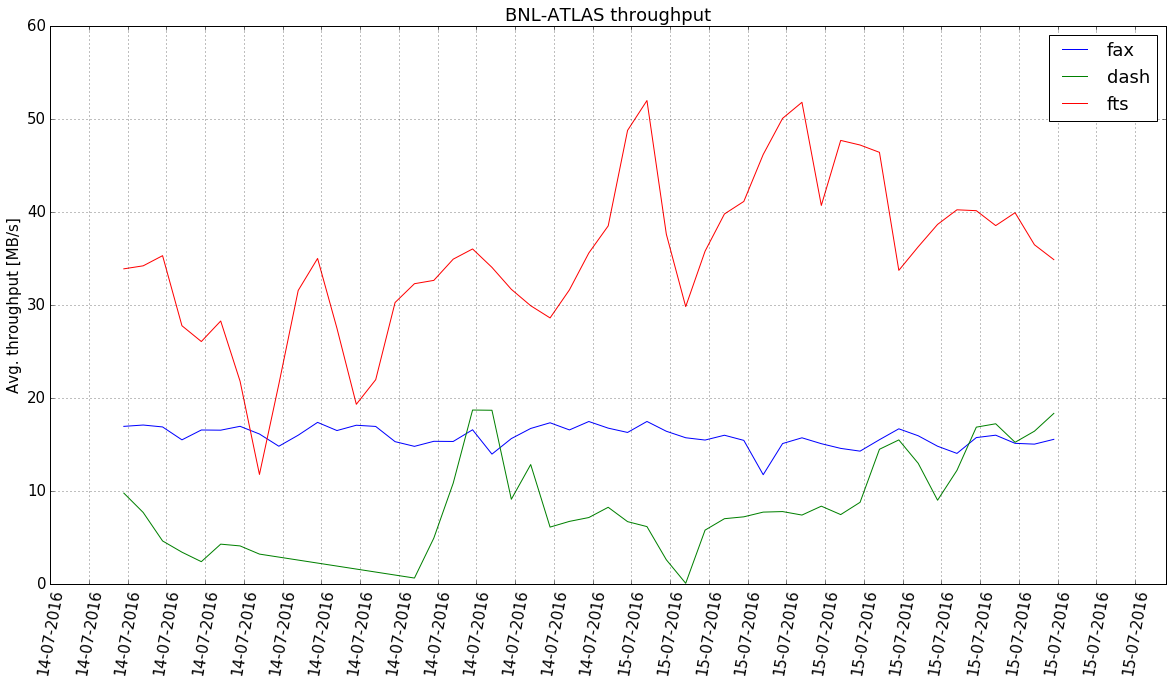

In [27]:
import matplotlib.dates as dt

centerName = 'BNL-ATLAS'

faxTimestamp = dt.epoch2num(faxTime[centerName]/1000.)
faxThroughput = faxThroughputHist[centerName]

ftsTimestamp = dt.epoch2num(ftsTime[centerName]/1000.)
ftsThroughput = ftsThroughputHist[centerName]

dashTimestamp = dt.epoch2num(dashTime[centerName]/1000.)
dashThroughput = dashThroughputHist[centerName]



plt.figure(figsize=(20,10))

plt.plot(faxTimestamp,faxThroughput,label='fax')
plt.plot(dashTimestamp,dashThroughput,label='dash')
plt.plot(ftsTimestamp,ftsThroughput,label='fts')
plt.legend()


ax = plt.gca()
#Tedious date/time formatting
xfmt = dt.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis_date()

plt.ylabel('Avg. throughput [MB/s]')

#Manually add extra ticks to histogram plots
start, end = ax.get_xlim()
plt.xticks(np.arange(start, end,ticks),rotation= 80 )
plt.grid()
plt.title('%s throughput'%centerName)
plt.show()